In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
import diffusionstuff6_1 as ds
from copy import copy as dup
from scipy.integrate import odeint

In [2]:
# Graphics parameters
%matplotlib notebook
ticklabelsize = 11
fontsize = 15
linewidth = 2
fignum = 0

### The cell below specifies parameters for the 0-d and 1-d runs

<IPython.core.display.Javascript object>


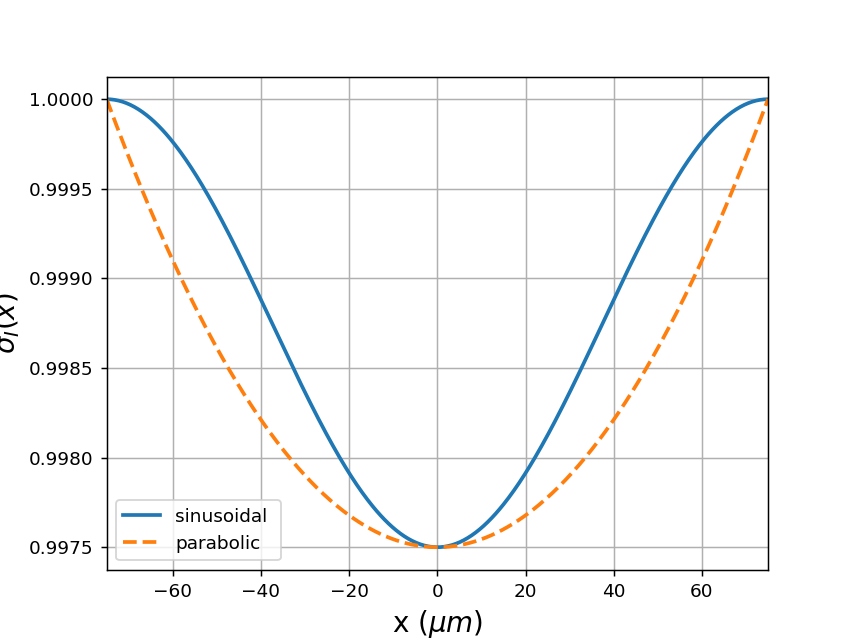

0.8333333333333334
sinusoid: 357.11646835877116
paraboloic: 329.5682114433066
D = 0.00016 um^2/us 0.16 x 10^-9 m^2/sec
deltat_max (Diffusion time) = 562.4999999999999
deltat = 11.249999999999998
deprate = 0.8333333333333334 monolayers/us
nmid = 250
N* = 0.1432394487827058
N*x2pi = 0.9
Nbar, Nbar-N*, N*/Nbar = 1.0 0.8567605512172942 0.1432394487827058
deltax = 0.3
sigma_0 = 0.19
sigmaIcorner = 0.22
center reduction = 0.25 %
c_r = 0.0025 dimensionless
max growth rate = 55.00000000000001 um/sec
min growth rate = 7.5 um/sec
nu_kin = 250 um/sec
dx = 0.3
L = 75.0 micrometers


In [3]:
#Setting up the system
nx = 501 # Number of points in simulation box
xmax = 150
x = np.linspace(0, xmax, nx)
boxpoints = len(x)
deltax = x[1]-x[0]
Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot = np.ones(nx)
NQLL = ds.getNliq(Ntot,Nstar,Nbar)
Nice = Ntot-NQLL

# Lay out the system
Ntot = NQLL + Nice
nmid = int(nx/2)
nquart = int(nx/4)
xmid = max(x)/2
xmax = x[nx-1]
Nice_start = Nice[0]

# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
# D = 2e-4 # micrometers^2/microsecond
D = 1.6e-4 # micrometers^2/microsecond
# D = 5e-5 # micrometers^2/microsecond
# D = 8e-6 # micrometers^2/microsecond
# D = 2e-7 # micrometers^2/microsecond

# Time steps
dtmaxtimefactor = 50
dtmax = deltax**2/D
deltat = dtmax/dtmaxtimefactor

# Deposition rate
nu_kin = 34 # microns/second - about right for 240 K
nu_kin = 49 # microns/second - between 240 and 260 K
nu_kin = 250 # microns/second - about right for 260 K
deprate = nu_kin/umpersec_over_mlyperus # monolayers per microsecond
deprate_times_deltat = deprate * deltat

# Supersaturation
sigma0 = 0.19
sigmaIcorner = 0.20 # Must be bigger than sigma0 to get growth
sigmaIcorner = 0.22 # Must be bigger than sigma0 to get growth
center_reduction = 0.25 # In percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time-step and space-step
Doverdeltax2 = D/deltax**2

# Gets the function sigma(x)
sigmaI_sinusoid = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='sinusoid') #NOTE i think this should be nx not xmax
sigmaI_parabolic = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='parabolic')
# sigmaIstyle = 'sinusoid'
sigmaIstyle = 'parabolic'
if sigmaIstyle=='sinusoid':
    sigmaI = sigmaI_sinusoid
elif sigmaIstyle=='parabolic':
    sigmaI = sigmaI_parabolic
else:
    print('bad choice')

# Graph sigma(x)
plt.figure()
plt.plot(x-xmid,sigmaI_sinusoid/sigmaIcorner, \
         x-xmid, sigmaI_parabolic/sigmaIcorner, '--',lw=linewidth)
plt.xlim([-xmid,xmid])
plt.legend(['sinusoidal ', 'parabolic'])
plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
plt.grid('on')

# These are run control parameters

# Flag for explicit updating NQLL(Ntot) every step
updatingNQLL = False

# Set up a maximum number of iterations or layers
uselayers = True

# 0D run
if uselayers:
    layermax_0D = 100
else:
    countermax_0D = 100

# 1D run 
if uselayers:
    layermax_1D = 250
else:
    countermax_1D = 15000

#Parameters for 1-D run 
L = xmax/2
c_r = center_reduction / 100; 
nu_kin_ml = deprate; print(nu_kin_ml) # monolayers per microsecond
# sigma_I = sigmaIcorner; print('sigmaI ', sigma_I) # dimensionless
M = np.array([.0027, .0025])
B = np.array([2.9, 1.59])
beta = np.array([0.65, 0.65])
xfactor = nu_kin_ml*L**2*c_r**beta*sigmaIcorner/D
NSS = M*xfactor + B
print('sinusoid:', NSS[0])
print('paraboloic:', NSS[1])
    
# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec')
print('deltat_max (Diffusion time) =', dtmax)
print('deltat =', deltat)
print('deprate =', deprate, 'monolayers/us')
print('nmid =', nmid)
print('N* =', Nstar)
print('N*x2pi =', Nstar*2*np.pi)
print('Nbar, Nbar-N*, N*/Nbar =', Nbar, Nbar-Nstar, Nstar/Nbar)
print('deltax =', deltax)
print('sigma_0 =', sigma0)
print('sigmaIcorner =', sigmaIcorner)
print('center reduction =', center_reduction, '%')
print('c_r =', c_r, 'dimensionless')
print('max growth rate =', deprate*sigmaIcorner*umpersec_over_mlyperus, 'um/sec')
print('min growth rate =', deprate*(sigmaIcorner-sigma0)*umpersec_over_mlyperus, 'um/sec')
print('nu_kin =', nu_kin, 'um/sec')
print('dx =', deltax)
print('L =', L, 'micrometers')

### This is the 0-d run

In [4]:
# Bundle parameters for ODE solver
params = [Nbar, Nstar, sigmaIcorner, sigma0, deprate]

y0 = [Nbar,0.0]
ylast = dup(y0)

# Time steps
t0 = 0.0
ttot = 0.0
tinterval = [t0, deltat]

# Initialize the keeper arrays
tkeep_0D = [t0]
ykeep_0D = [y0]
tlast = dup(t0)
Nicelast0 = 0.0
Ntotlast0 = 0.0
Nicelast_start = 0.0
Ntotlast_start = 0.0

# Call the ODE solver
counter = 0
layer = 0
while True:
    
    # Integrate up to next time step
    y = odeint(ds.f0d, ylast, tinterval, args=(params,),rtol=1e-12)
    ylast = list(y[1,:])
    tlast += deltat
    
    # Stuff into keeper arrays
    ykeep_0D.append(ylast)
    tkeep_0D.append(tlast)
    
    # Make some local copies, with possible updates to NQLL
    NQLLlast, Ntotlast = ylast
    Nicelast = Ntotlast - NQLLlast
    Nicelast0 = dup(Nicelast)
    Ntotlast0 = dup(Ntotlast)
    
    # Update counters and see whether to break
    counter += 1
    layer = dup(Ntotlast0) 
    if uselayers:
        if layer > layermax_0D-1:
            break
    else:
        if counter > countermax_0D-1:
            break
    
# Convert results to a numpy array
ykeep_0Darr = np.array(ykeep_0D, np.float64)
tkeep_0Darr = np.array(tkeep_0D, np.float64)

0-D Modeled growth rate, um/s 17.855521828136816
0-D Modeled growth rate, ml/us 0.05951840609378939
0-D Modeled alpha 0.3246458514206694


<IPython.core.display.Javascript object>


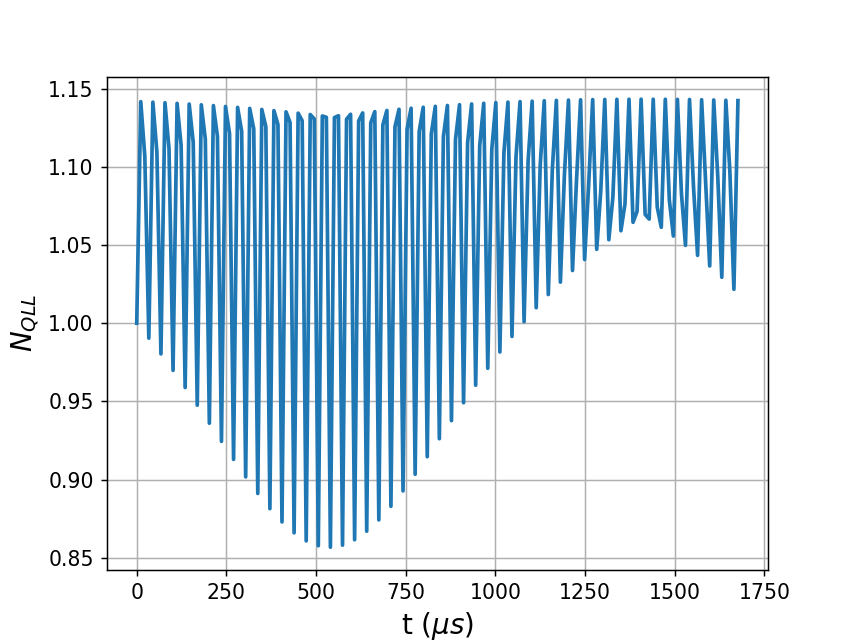

In [5]:
# Growth statistics
delta_Ntot_0d = Ntotlast0-Ntotlast_start
growthrate_0d_mlyperus = delta_Ntot_0d/tlast # monolayer/us
growthrate_0d = growthrate_0d_mlyperus*umpersec_over_mlyperus # um/sec
print( "0-D Modeled growth rate, um/s", growthrate_0d)
print( "0-D Modeled growth rate, ml/us", growthrate_0d_mlyperus)
alpha_0d = growthrate_0d/nu_kin/sigmaIcorner
print( "0-D Modeled alpha", alpha_0d)

# Plot results
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0Darr[:,0],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')


### This is the 1-d run

In [6]:
# Bundle parameters for ODE solver
params = [Nbar, Nstar, sigmaI, sigma0, deprate, Doverdeltax2, nx] 

# Initial conditions for ODE solver
y0 = np.array([NQLL,Ntot])
ylast = dup(y0)

# Initialize the keeper arrays
tkeep = [t0]
Nicekeep = [dup(Nice)]
Ntotkeep = [dup(Ntot)]
NQLLkeep = [dup(NQLL)]
fluxderivskeep = []

# Call the ODE solver
Nice0_start = Nice[0]
Nice0 = Nice[0]
Ntot0_start = Ntot[0]
Ntot0 = Ntot[0]
counter = 0
lastlayer = 0
lastdiff = 0

while True:
    # Integrate up to next time step
    y = odeint(ds.f1d, np.reshape(ylast,2*nx), tinterval, args=(params,),rtol=1e-12)

    ylast = np.reshape(y[1],(2,nx))
    tlast += deltat
    counter += 1
        
    # Make some local copies, with possible updates to NQLL
    NQLL, Ntot = ylast
    Nice = Ntot - NQLL
    Nice0 = Nice[0]
    Ntot0 = Ntot[0]
    ttot += deltat

    # Stuff into keeper arrays
    Nicekeep.append(Nice)
    Ntotkeep.append(Ntot)
    NQLLkeep.append(NQLL)
    tkeep.append(ttot)

    # Update counters and see whether to break
    layer = Ntot0-Ntot0_start
    if (layer-lastlayer) > 0:
        minpoint = min(Nice)
        maxpoint = max(Nice)
        print(counter-1, int(layer), maxpoint-minpoint)
        lastdiff = maxpoint-minpoint
        lastlayer += 1
    if uselayers:
        if layer > layermax_1D-1:
            print('breaking because reached max number of layers')
            break
    else:
        if counter > countermax_1D-1:
            print('breaking because reached max number of iterations')
            break

0 0 0.0028061187030752333
1 1 0.0031660225318808077
2 2 0.0632258934509431
4 3 0.008593079225673872
5 4 0.12184459587495056
7 5 0.013840671815984251
8 6 0.17631086289372888
10 7 0.018865401237109225
11 8 0.22719641551477388
13 9 0.02362791295611899
14 10 0.2750296880863665
16 11 0.02809526019250619
17 12 0.32021896496722313
19 13 0.03225934998291713
20 14 0.36307710692334716
22 15 0.03617365134774353
23 16 0.40383698504813026
25 17 0.04001718197137194
26 18 0.442654897683429
28 19 0.04420559323027362
29 20 0.4796182280657213
31 21 0.04956765087867865
32 22 0.5147712675274434
34 23 0.05757614011120182
35 24 0.548134371787544
37 25 0.07054175590338829
38 26 0.5797068826957386
40 27 0.09151704252582249
41 28 0.6094751219082113
43 29 0.12354104687758394
44 30 0.637428693445532
46 31 0.168164006085064
47 32 0.6635669592575866
49 33 0.22411406198194328
50 34 0.6879066641857179
52 35 0.28741227785200607
53 36 0.7104829317212378
55 37 0.353035838096325
56 38 0.7313496303601354
58 39 0.41671220

Height of Ice 0
1-D growth, corner 249.5096735123599
1-D growth, center 247.75166393705814
1-D Modeled growth rate, corner, um/s 17.790351052574685
1-D Modeled growth rate, corner, ml/us 0.05930117017524895
1-D Modeled growth rate, center, um/s 17.665002776260835
1-D Modeled alpha, corner 0.3234866001252165
1-D Modeled alpha, center 0.32198683574865955
Difference, % -0.4636248846092641
0-D Modeled growth rate, um/s 17.855521828136816
0-D Modeled growth rate, ml/us 0.05951840609378938
0-D Modeled alpha 0.3246458514206694
Growth ratio 1D (corner)/0D 0.9963501052397453
Growth ratio 1D (center)/0D 0.9893299644944703
Contribution of diffusion -1.0670035505529731 %
Libbrecht's predicted growth rate, um/s 10.705216497342732
Libbrecht's predicted alpha 0.19464029995168605
Time taken: 0 min 0.00039005279541015625 secs


<IPython.core.display.Javascript object>


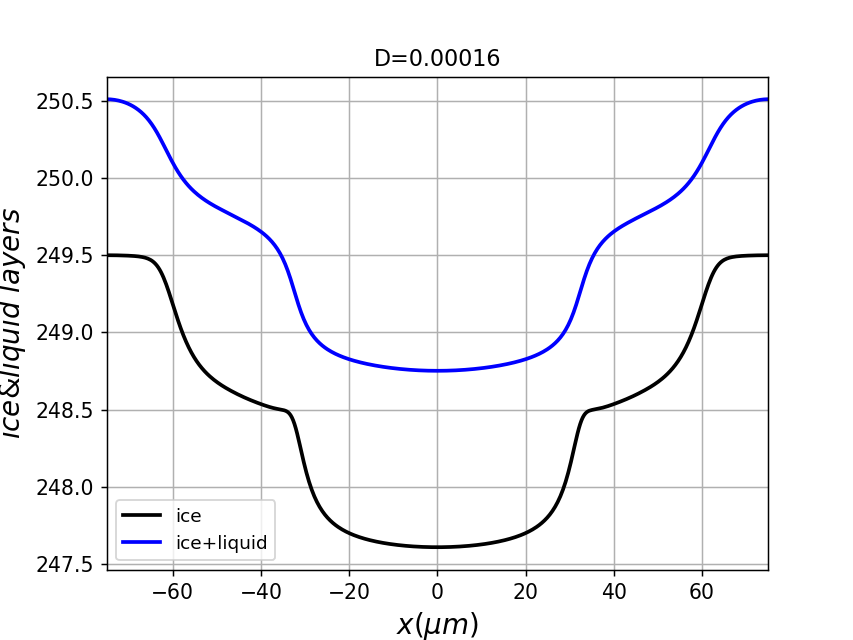

<IPython.core.display.Javascript object>


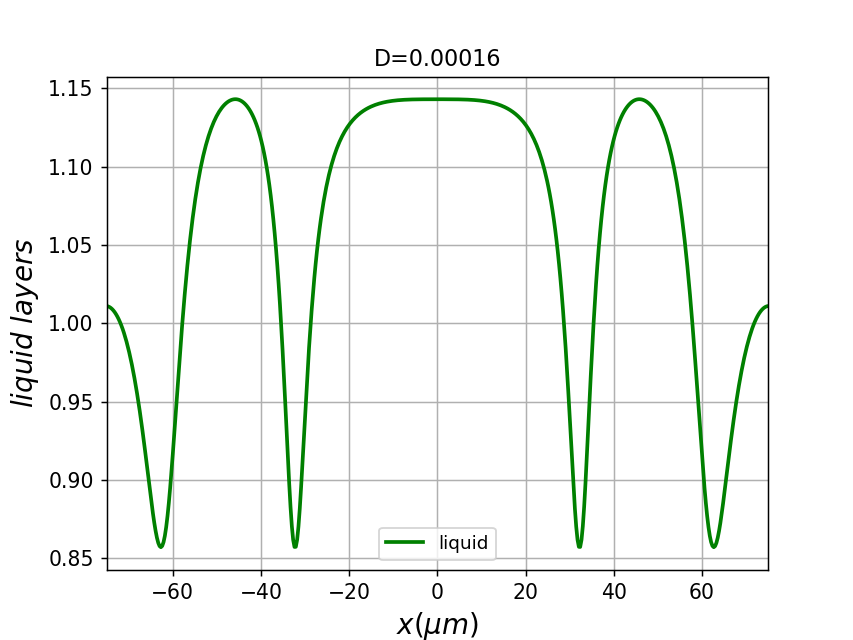

<IPython.core.display.Javascript object>


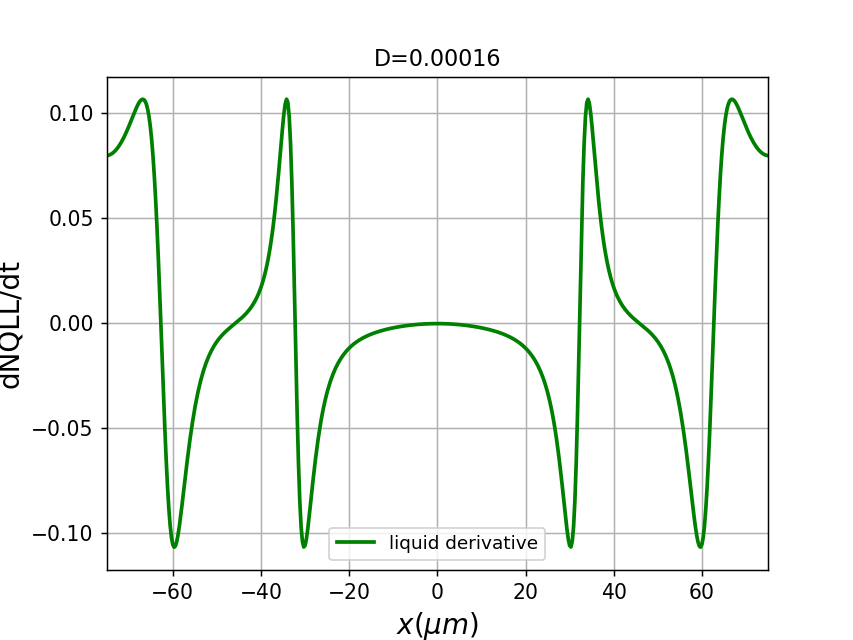

<IPython.core.display.Javascript object>


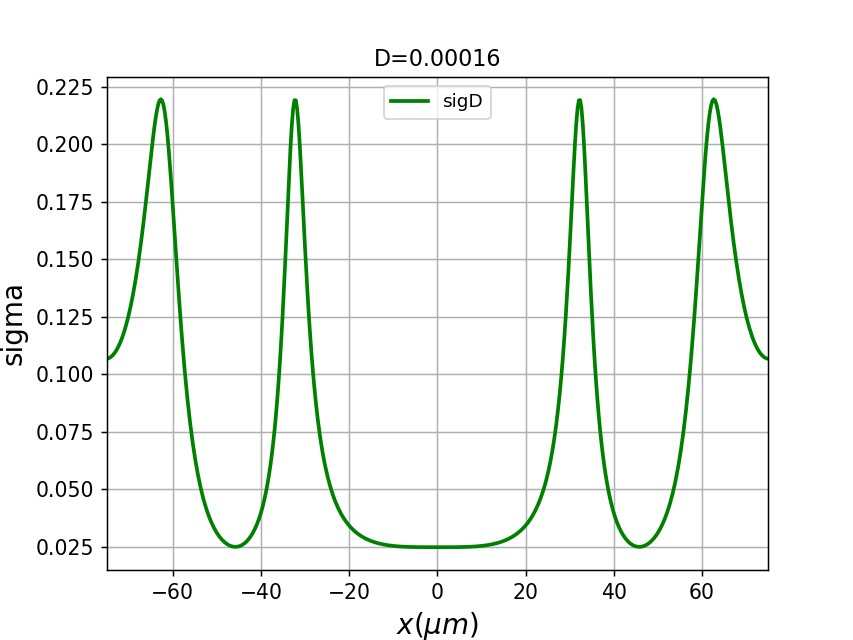

<IPython.core.display.Javascript object>


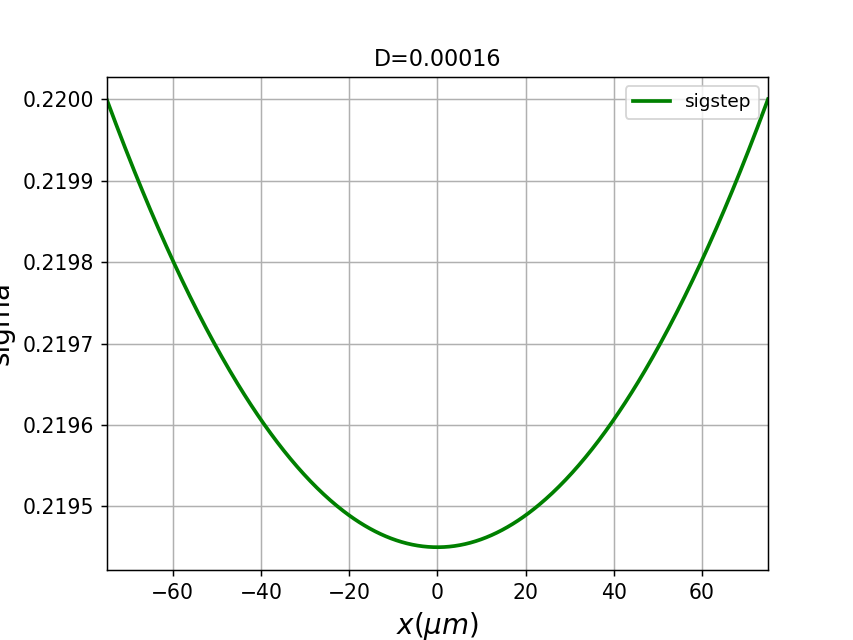

<IPython.core.display.Javascript object>


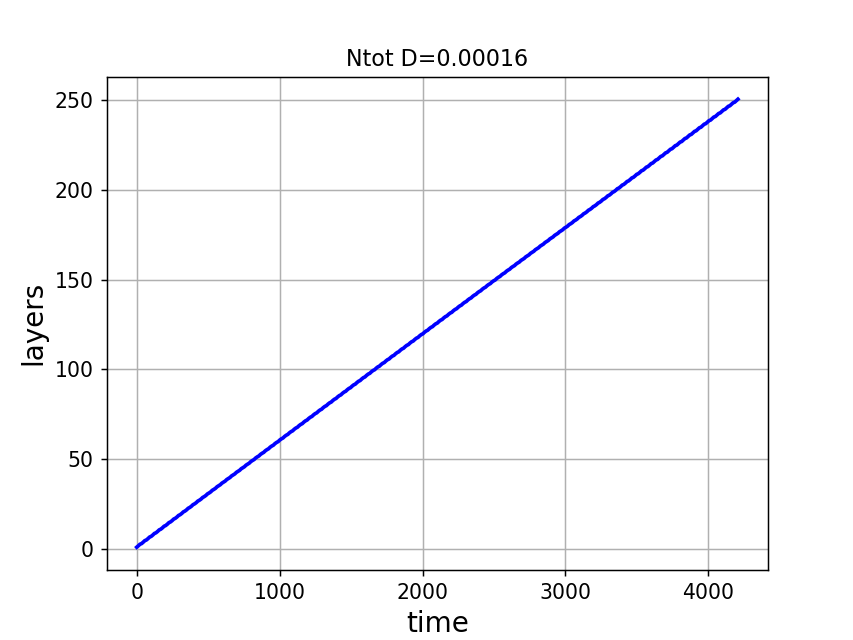

<IPython.core.display.Javascript object>


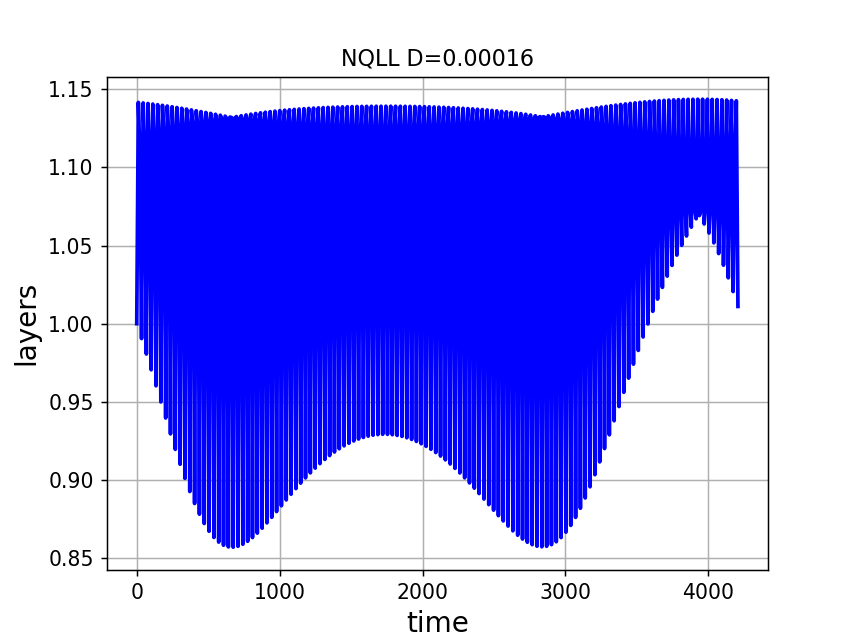

<IPython.core.display.Javascript object>


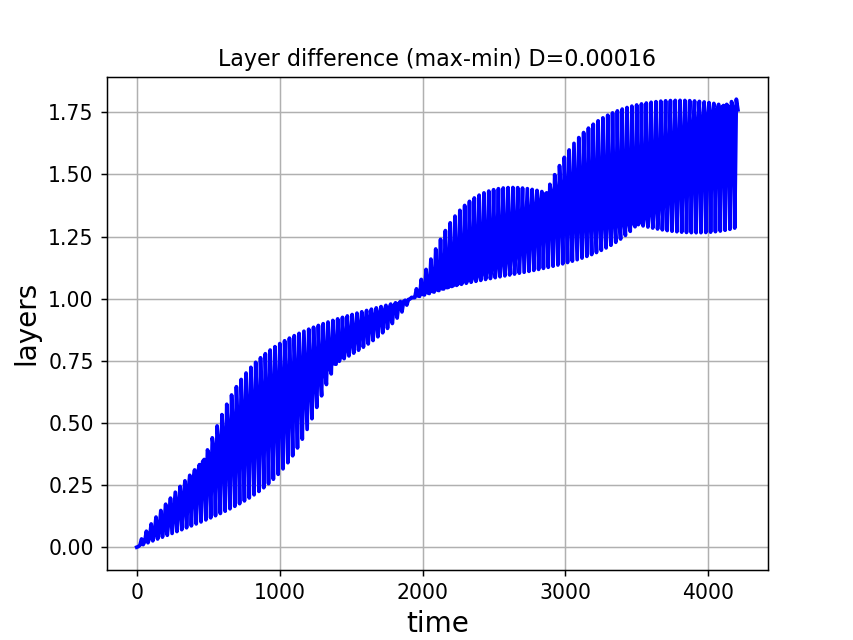

Text(0.5, 1.0, 'Layer difference (max-min) D=0.00016')

In [7]:
# Growth statistics
sec1 = time.time()

# minpoint = min(Nice)
minpoint = 0
ncorner = 4
print("Height of Ice", minpoint)
delta_Ntot_entire = Ntot-Ntotkeep[0]
print( "1-D growth, corner", delta_Ntot_entire[ncorner])
print( "1-D growth, center", delta_Ntot_entire[nmid])
growthrate_entire = delta_Ntot_entire/ttot*umpersec_over_mlyperus
print( "1-D Modeled growth rate, corner, um/s", growthrate_entire[ncorner])
print( "1-D Modeled growth rate, corner, ml/us", growthrate_entire[ncorner]/umpersec_over_mlyperus)
print( "1-D Modeled growth rate, center, um/s", growthrate_entire[nmid])
alpha = growthrate_entire/nu_kin/sigmaI
print( "1-D Modeled alpha, corner", alpha[ncorner])
print( "1-D Modeled alpha, center", alpha[nmid])
print( "Difference, %", (alpha[nmid]-alpha[ncorner])/alpha[ncorner]*100)


# Comparisons with 0-D model
print( "0-D Modeled growth rate, um/s", growthrate_0d)
print( "0-D Modeled growth rate, ml/us", growthrate_0d/umpersec_over_mlyperus)
print( "0-D Modeled alpha", alpha_0d)
print( "Growth ratio 1D (corner)/0D", growthrate_entire[ncorner]/growthrate_0d)
print( "Growth ratio 1D (center)/0D", growthrate_entire[nmid]/growthrate_0d)
print( "Contribution of diffusion", (growthrate_entire[nmid]-growthrate_0d)/growthrate_0d*100, '%')

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmaIcorner)
print("Libbrecht's predicted growth rate, um/s", nu_kin*alpha_L*sigmaIcorner)
print("Libbrecht's predicted alpha", alpha_L)

# Timing statistics
sec2 = time.time()
print("Time taken:", int((sec2-sec1)/60), "min", (sec2-sec1)%60, "secs")

title = 'D='+str(D)

# Plot ice and liquid
plt.figure()
plt.plot(x-xmid, Nice-minpoint, 'k', label='ice', lw=linewidth)
plt.plot(x-xmid, NQLL+Nice-minpoint, 'b', label='ice+liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice & liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot liquid only
plt.figure()
plt.plot(x-xmid, NQLL, 'g', label='liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot derivatives
dydx = ds.f1d(ylast,0,params)
dydx = np.reshape(dydx,(2,nx))
plt.figure()
plt.plot(x-xmid, dydx[0,:], 'g', label='liquid derivative', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel('dNQLL/dt',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot sigma_m
sigD = ds.f1d_sigma_m(ylast,0,params)
plt.figure()
plt.plot(x-xmid, sigD, 'g', label='sigD', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel('sigma',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot sigma
plt.figure()
plt.plot(x-xmid, sigmaI, 'g', label='sigstep', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel('sigma',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# The liquid over time
ix = 0
Ntotkeep_at_one_position = np.array(Ntotkeep)[:,ix]
plt.figure()
plt.plot(tkeep, Ntotkeep_at_one_position, 'b', label='total', lw=linewidth)
plt.xlabel('time',fontsize=fontsize)
plt.ylabel('layers',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')
plt.title('Ntot '+title)

# 
ix = 0
NQLLkeep_at_one_position = np.array(NQLLkeep)[:,ix]
plt.figure()
plt.plot(tkeep, NQLLkeep_at_one_position, 'b', label='liquid', lw=linewidth)
plt.xlabel('time',fontsize=fontsize)
plt.ylabel('layers',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')
plt.title('NQLL '+title)


Ntot_difference = np.array(Ntotkeep)[:,-1] - np.array(Ntotkeep)[:,nmid]
plt.figure()
plt.plot(tkeep, Ntot_difference, 'b', label='number of steps', lw=linewidth)
plt.xlabel('time',fontsize=fontsize)
plt.ylabel('layers',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')
plt.title('Layer difference (max-min) '+title)

### The cell below is just backup for parameters, and allows some exploration (but not part of the simulation)

In [8]:
# The time required for an initial gaussian to diffuse
layer_growth_rate = growthrate_0d/umpersec_over_mlyperus; print('Layer growth rate =', layer_growth_rate)
t1 = 1/layer_growth_rate; print('Time_to_add_a_layer =', t1)
t2 = 2.5**2/D; print('Time to diffuse across a terrace =', t2)
t3 = 0.2**2/D; print('Time to diffuse into a step =', t3)
t4 = 0.001; print('Time for ice-QLL equilibration =', t4)

# How a change in the crystal size could be used to calculate a new diffusion coefficient with the same D/dx^2
D_old = 2e-6
D_new = D_old/50**2*100**2; print(D_new)

# Computing the kinetic deposition velocity ... roughly, 260 
import numpy as np
M = 18 # g/mol
T = 260 # K
NA = 6.02e23
m = M/NA; print(m,'mass of a molecule of water, grams/mol')
m /= 1e3; print(m,'mass of a molecule of water, kg/mol')
R = 8.314 # J/K-mol
k = R/NA; print(k,"Boltzmann's constant, J/K")

Pvap = 200 # Pascals (see https://byjus.com/clausius-clapeyron-equation-calculator/)
V_gas = R*T/Pvap # Must be in m^3
V_gas *= (10/1)**3; print(V_gas, 'Liters') 
V_gas *= (10/1)**3; print(V_gas, 'cm^3') # see https://www.omnicalculator.com/physics/ideal-gas-law
c_sat = 1/V_gas # mol/cm^3
c_sat*=M; print(c_sat,'density of vapor, g/cm^3')

c_solid = 0.92; print(c_solid, 'density of ice, g/cm^3')
V_solid = 1/c_solid # cm^3/g

V_ratio = V_gas/V_solid; print(V_ratio,'ratio of volumes')
c_ratio = c_sat/c_solid; print(c_ratio,'ratio of densities')

sqrtfactor = np.sqrt(k*T/(2*np.pi*m))
nukin = c_sat/c_solid*sqrtfactor; print(nukin,'kinetic velocity, m/s')
nukin *= 1e6; print(nukin, 'kinetic velocity, um/s')

# Computing the kinetic deposition velocity ... roughly, 240 K has nukin of 40 um/s (we used 49 um/s in the paper)
M = 18 # g/mol
T = 240 # K
NA = 6.02e23
m = M/NA; print(m,'mass of a molecule of water, grams/mol')
m /= 1e3; print(m,'mass of a molecule of water, kg/mol')
R = 8.314 # J/K-mol
k = R/NA; print(k,"Boltzmann's constant, J/K")

Pvap = 26 # Pascals (see https://byjus.com/clausius-clapeyron-equation-calculator/)
V_gas = R*T/Pvap # Must be in m^3
V_gas *= (10/1)**3; print(V_gas, 'Liters') 
V_gas *= (10/1)**3; print(V_gas, 'cm^3') # see https://www.omnicalculator.com/physics/ideal-gas-law
c_sat = 1/V_gas # mol/cm^3
c_sat*=M; print(c_sat,'density of vapor, g/cm^3')

c_solid = 0.92; print(c_solid, 'density of ice, g/cm^3')
V_solid = 1/c_solid # cm^3/g

V_ratio = V_gas/V_solid; print(V_ratio,'ratio of volumes')
c_ratio = c_sat/c_solid; print(c_ratio,'ratio of densities')

sqrtfactor = np.sqrt(k*T/(2*np.pi*m))
nukin = c_sat/c_solid*sqrtfactor; print(nukin,'kinetic velocity, m/s')
nukin *= 1e6; print(nukin, 'kinetic velocity, um/s')

# Gladich et al recommendation
D_Gladich = 0.16e-9 # m^2/s
D_Gladich *= (1e6/1)**2*(1/1e6); print('Gladich says, for 260 K, D = ', D_Gladich)

Layer growth rate = 0.05951840609378938
Time_to_add_a_layer = 16.80152520254315
Time to diffuse across a terrace = 39062.5
Time to diffuse into a step = 250.00000000000003
Time for ice-QLL equilibration = 0.001
8e-06
2.990033222591362e-23 mass of a molecule of water, grams/mol
2.9900332225913625e-26 mass of a molecule of water, kg/mol
1.381063122923588e-23 Boltzmann's constant, J/K
10808.199999999999 Liters
10808199.999999998 cm^3
1.6654021946300035e-06 density of vapor, g/cm^3
0.92 density of ice, g/cm^3
9943543.999999998 ratio of volumes
1.810219776771743e-06 ratio of densities
0.0002502630900698087 kinetic velocity, m/s
250.26309006980867 kinetic velocity, um/s
2.990033222591362e-23 mass of a molecule of water, grams/mol
2.9900332225913625e-26 mass of a molecule of water, kg/mol
1.381063122923588e-23 Boltzmann's constant, J/K
76744.61538461539 Liters
76744615.38461539 cm^3
2.345441424103921e-07 density of vapor, g/cm^3
0.92 density of ice, g/cm^3
70605046.15384616 ratio of volumes
2